In [1]:
import pandas as pd
import re
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [130]:
df=pd.read_csv("TurkishTweets.csv")
df.head()

,Tweet,Etiket
0,Allah'ım çıldıracağım. Yemin ederim çıldıracağ...,kızgın
1,site ne zaman çalıştıda ürün stokları bitti di...,kızgın
2,Sebebi neydi ki diye bağıracağım şimdi az kaldı,kızgın
3,Black friday ne amk bu yıl çıkardınız bu bokud...,kızgın
4,kısa kısa cevaplar vericeksen niye yazıyorsun ...,kızgın


Data preprocessing

<AxesSubplot:xlabel='Etiket', ylabel='count'>

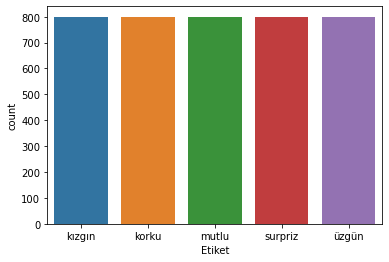

In [131]:
sns.countplot(x=df.Etiket)

In [132]:
sent_dict={'kızgın':0,'korku':1,'mutlu':2,'surpriz':3,'üzgün':4}
df["Etiket"]=df["Etiket"].map(sent_dict)
df.head()

,Tweet,Etiket
0,Allah'ım çıldıracağım. Yemin ederim çıldıracağ...,0
1,site ne zaman çalıştıda ürün stokları bitti di...,0
2,Sebebi neydi ki diye bağıracağım şimdi az kaldı,0
3,Black friday ne amk bu yıl çıkardınız bu bokud...,0
4,kısa kısa cevaplar vericeksen niye yazıyorsun ...,0


In [133]:
def clean_text(text):
    unwanted_pattern=r'[!.\n,:“”,?@#"]'
    regax=re.compile(unwanted_pattern)
    cleaned_text=regax.sub(" ",text)
    return cleaned_text
df["new_text"]=df["Tweet"].astype(str).apply(clean_text)
df["new_text"]=df["new_text"].str.replace("[\d]", "")
df["new_text"]=df["new_text"].str.lower()
df

,Tweet,Etiket,new_text
0,Allah'ım çıldıracağım. Yemin ederim çıldıracağ...,0,allah'ım çıldıracağım yemin ederim çıldıracağ...
1,site ne zaman çalıştıda ürün stokları bitti di...,0,site ne zaman çalıştıda ürün stokları bitti di...
2,Sebebi neydi ki diye bağıracağım şimdi az kaldı,0,sebebi neydi ki diye bağıracağım şimdi az kaldı
3,Black friday ne amk bu yıl çıkardınız bu bokud...,0,black friday ne amk bu yıl çıkardınız bu bokud...
4,kısa kısa cevaplar vericeksen niye yazıyorsun ...,0,kısa kısa cevaplar vericeksen niye yazıyorsun ...
...,...,...,...
3995,Aynı şeyleri yapmaktan sıkıldım,4,aynı şeyleri yapmaktan sıkıldım
3996,"Olacağı varsa oluyor ya hani, biteceği varsa d...",4,olacağı varsa oluyor ya hani biteceği varsa d...
3997,Çok şey istiyorum ama sonu hep fiyasko MUTSUZUM,4,çok şey istiyorum ama sonu hep fiyasko mutsuzum
3998,Garip bir şekilde canım çok yanıyor moralim bozuk,4,garip bir şekilde canım çok yanıyor moralim bozuk


In [134]:
df=df.dropna()
df.isna().sum()

Tweet       0
Etiket      0
new_text    0
dtype: int64

In [135]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
ineffective=stopwords.words("Turkish")
ineffective[:5]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['acaba', 'ama', 'aslında', 'az', 'bazı']

In [136]:
df["new_text"]=df["new_text"].apply(lambda x: " ".join(x for x in x.split() if x not in ineffective))
df.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_11560\61437244.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["new_text"]=df["new_text"].apply(lambda x: " ".join(x for x in x.split() if x not in ineffective))


,Tweet,Etiket,new_text
0,Allah'ım çıldıracağım. Yemin ederim çıldıracağ...,0,allah'ım çıldıracağım yemin ederim çıldıracağı...
1,site ne zaman çalıştıda ürün stokları bitti di...,0,site zaman çalıştıda ürün stokları bitti diyor...
2,Sebebi neydi ki diye bağıracağım şimdi az kaldı,0,sebebi neydi bağıracağım şimdi kaldı
3,Black friday ne amk bu yıl çıkardınız bu bokud...,0,black friday amk yıl çıkardınız bokuda mal mıs...
4,kısa kısa cevaplar vericeksen niye yazıyorsun ...,0,kısa kısa cevaplar vericeksen yazıyorsun geriz...


Vectorizing

In [137]:
X_train, X_test, y_train, y_test = train_test_split(df['new_text'], df['Etiket'], test_size=0.25, random_state=42)

tf_vector = TfidfVectorizer(max_features =  5000)
ct_vector = CountVectorizer(max_features = 5000)
X_train_vec = tf_vector.fit_transform(X_train)
X_test_vec = tf_vector.transform(X_test)
X_train_ct = ct_vector.fit_transform(X_train)
X_test_ct = ct_vector.transform(X_test)

Machine Learning Model

Naive Bayes

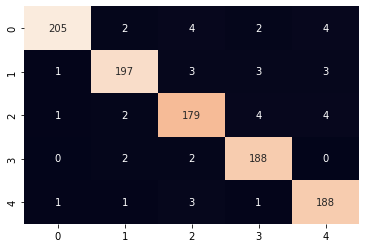

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       217
           1       0.97      0.95      0.96       207
           2       0.94      0.94      0.94       190
           3       0.95      0.98      0.96       192
           4       0.94      0.97      0.96       194

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



In [138]:
nb_tf = BernoulliNB()
nb_tf.fit(X_train_vec, y_train)

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cbar=False, fmt=".4g")
    plt.show()
    print(classification_report(y_test, y_pred))
    
result = pd.DataFrame(columns=['TF_Vectorizer_accuracy', 'Count_Vectorizer_accuracy', 'Model'])
    
evaluate_model(nb_tf, X_test_vec, y_test)
    

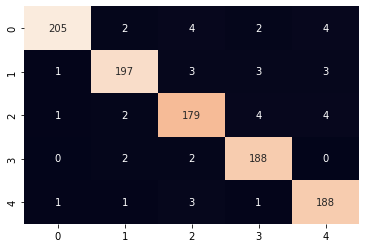

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       217
           1       0.97      0.95      0.96       207
           2       0.94      0.94      0.94       190
           3       0.95      0.98      0.96       192
           4       0.94      0.97      0.96       194

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



,TF_Vectorizer_accuracy,Count_Vectorizer_accuracy,Model
0,0.957,0.957,Naive Bayes


In [139]:
nb_ct = BernoulliNB()
nb_ct.fit(X_train_ct, y_train)
result = result.append({
                'Model': 'Naive Bayes',
                'Count_Vectorizer_accuracy':nb_ct .score(X_test_ct, y_test),
                'TF_Vectorizer_accuracy': nb_tf.score(X_test_vec, y_test)},
                ignore_index=True)
evaluate_model(nb_ct, X_test_ct, y_test)
result

Support Vector Machine

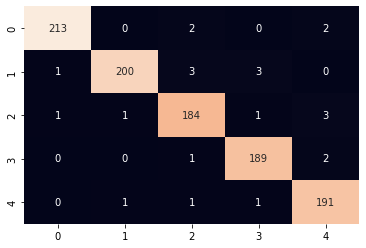

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       217
           1       0.99      0.97      0.98       207
           2       0.96      0.97      0.97       190
           3       0.97      0.98      0.98       192
           4       0.96      0.98      0.97       194

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



In [140]:
svc_tf = SVC()
svc_tf.fit(X_train_vec, y_train)
evaluate_model(svc_tf, X_test_vec, y_test)

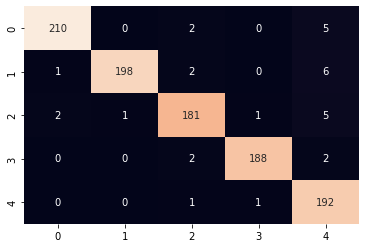

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       217
           1       0.99      0.96      0.98       207
           2       0.96      0.95      0.96       190
           3       0.99      0.98      0.98       192
           4       0.91      0.99      0.95       194

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



,TF_Vectorizer_accuracy,Count_Vectorizer_accuracy,Model
0,0.957,0.957,Naive Bayes
1,0.977,0.969,Support Vector Machine


In [141]:
svc_ct = SVC()
svc_ct.fit(X_train_ct, y_train)
evaluate_model(svc_ct, X_test_ct, y_test)
result = result.append({
                'Model': 'Support Vector Machine',
                'Count_Vectorizer_accuracy':svc_ct .score(X_test_ct, y_test),
                'TF_Vectorizer_accuracy': svc_tf.score(X_test_vec, y_test)},
                ignore_index=True)
result

Deep Learning Model

In [75]:
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
vocab_size = 10000 
embedding_dim = 16
max_length = 200
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_df["Tweet"])
word_index = tokenizer.word_index
y_train = train_df["Etiket"].values

train_sequences = tokenizer.texts_to_sequences(train_df["Tweet"])
train_padded = pad_sequences(train_sequences, maxlen=max_length)

validation_sequences = tokenizer.texts_to_sequences(test_df["Tweet"])
validation_padded = pad_sequences(validation_sequences, maxlen=max_length)
y_test = test_df["Etiket"].values

CNN

In [98]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


tf.random.set_seed(42)
cnn_model = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Conv1D(128, 5, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])

cnn_model.save('cnn.h5')
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
cnn_model.summary() 


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 200, 16)           160000    
                                                                 
 conv1d_13 (Conv1D)          (None, 196, 128)          10368     
                                                                 
 batch_normalization_3 (Batc  (None, 196, 128)         512       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 196, 128)          0         
                                                                 
 global_max_pooling1d_10 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_41 (Dense)            (None, 64)              

In [99]:
num_epochs = 30
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = cnn_model.fit(train_padded, y_train, epochs=num_epochs, validation_data=(validation_padded, y_test), verbose=2, callbacks=[early_stopping])

Epoch 1/30
100/100 - 8s - loss: 1.5493 - accuracy: 0.3063 - val_loss: 1.5912 - val_accuracy: 0.4875 - 8s/epoch - 84ms/step
Epoch 2/30
100/100 - 5s - loss: 0.6343 - accuracy: 0.7868 - val_loss: 1.3558 - val_accuracy: 0.9125 - 5s/epoch - 48ms/step
Epoch 3/30
100/100 - 5s - loss: 0.0688 - accuracy: 0.9812 - val_loss: 1.0319 - val_accuracy: 0.9438 - 5s/epoch - 47ms/step
Epoch 4/30
100/100 - 5s - loss: 0.0128 - accuracy: 0.9981 - val_loss: 0.6809 - val_accuracy: 0.9650 - 5s/epoch - 51ms/step
Epoch 5/30
100/100 - 5s - loss: 0.0059 - accuracy: 0.9984 - val_loss: 0.3720 - val_accuracy: 0.9688 - 5s/epoch - 49ms/step
Epoch 6/30
100/100 - 5s - loss: 0.0030 - accuracy: 0.9997 - val_loss: 0.1966 - val_accuracy: 0.9700 - 5s/epoch - 48ms/step
Epoch 7/30
100/100 - 5s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.1257 - val_accuracy: 0.9700 - 5s/epoch - 49ms/step
Epoch 8/30
100/100 - 5s - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.1023 - val_accuracy: 0.9725 - 5s/epoch - 48ms/step
Epoch 9/30
100/1

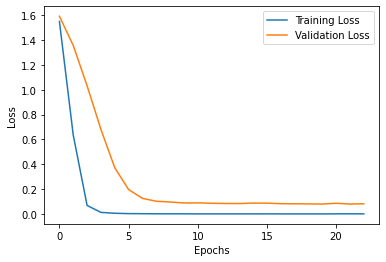

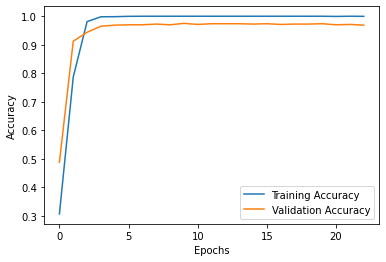

In [100]:
import matplotlib.pyplot as plt

# Training ve validation loss grafiği
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Training ve validation accuracy grafiği
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [101]:
def evaluate_model_dl(model, X_test, y_test):
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cbar=False, fmt=".4g")
    plt.show()
    print(classification_report(y_test, y_pred))
result_dl = pd.DataFrame(columns=['Accuracy', 'Model'])

25/25 [==============================] - 1s 12ms/step


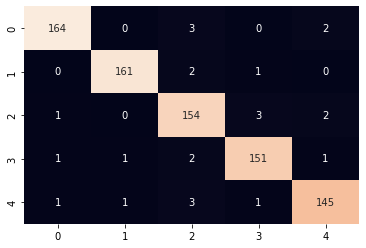

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       169
           1       0.99      0.98      0.98       164
           2       0.94      0.96      0.95       160
           3       0.97      0.97      0.97       156
           4       0.97      0.96      0.96       151

    accuracy                           0.97       800
   macro avg       0.97      0.97      0.97       800
weighted avg       0.97      0.97      0.97       800



In [102]:
evaluate_model_dl(cnn_model, validation_padded, y_test)

In [103]:
result_dl = result_dl.append({
                'Model': 'CNN',
                'Accuracy': cnn_model.evaluate(validation_padded, y_test)[1]},
                ignore_index=True)
result_dl

25/25 [==============================] - 0s 12ms/step - loss: 0.0821 - accuracy: 0.9688


,Accuracy,Model
0,0.969,CNN


LSTM

In [109]:
from tensorflow.keras.layers import LSTM,Bidirectional

lstm_model = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])
lstm_model.save('lstm.h5')

lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 200, 16)           160000    
                                                                 
 lstm_13 (LSTM)              (None, 32)                6272      
                                                                 
 dense_49 (Dense)            (None, 32)                1056      
                                                                 
 dense_50 (Dense)            (None, 5)                 165       
                                                                 
Total params: 167,493
Trainable params: 167,493
Non-trainable params: 0
_________________________________________________________________


In [110]:
num_epochs = 30
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
lstm_history = lstm_model.fit(train_padded, y_train, epochs=num_epochs, validation_data=(validation_padded, y_test), verbose=2, callbacks=[early_stopping])

Epoch 1/30
100/100 - 20s - loss: 1.5623 - accuracy: 0.3682 - val_loss: 1.3088 - val_accuracy: 0.7113 - 20s/epoch - 203ms/step
Epoch 2/30
100/100 - 12s - loss: 0.8922 - accuracy: 0.7624 - val_loss: 0.4690 - val_accuracy: 0.8737 - 12s/epoch - 120ms/step
Epoch 3/30
100/100 - 12s - loss: 0.1516 - accuracy: 0.9762 - val_loss: 0.2690 - val_accuracy: 0.9125 - 12s/epoch - 117ms/step
Epoch 4/30
100/100 - 12s - loss: 0.0291 - accuracy: 0.9966 - val_loss: 0.2251 - val_accuracy: 0.9250 - 12s/epoch - 119ms/step
Epoch 5/30
100/100 - 12s - loss: 0.0494 - accuracy: 0.9959 - val_loss: 0.2113 - val_accuracy: 0.9312 - 12s/epoch - 119ms/step
Epoch 6/30
100/100 - 12s - loss: 0.0087 - accuracy: 0.9994 - val_loss: 0.1920 - val_accuracy: 0.9337 - 12s/epoch - 116ms/step
Epoch 7/30
100/100 - 12s - loss: 0.0045 - accuracy: 0.9997 - val_loss: 0.2298 - val_accuracy: 0.9275 - 12s/epoch - 117ms/step
Epoch 8/30
100/100 - 12s - loss: 0.0041 - accuracy: 0.9997 - val_loss: 0.1863 - val_accuracy: 0.9400 - 12s/epoch - 120

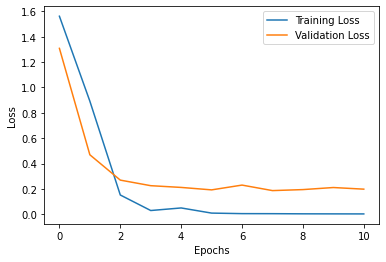

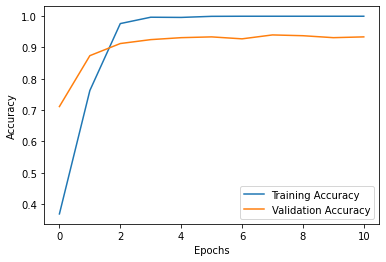

In [111]:
import matplotlib.pyplot as plt

# Training ve validation loss grafiği
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Training ve validation accuracy grafiği
plt.plot(lstm_history.history['accuracy'], label='Training Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

25/25 [==============================] - 3s 45ms/step


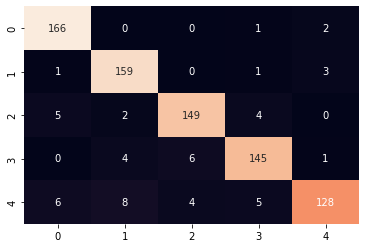

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       169
           1       0.92      0.97      0.94       164
           2       0.94      0.93      0.93       160
           3       0.93      0.93      0.93       156
           4       0.96      0.85      0.90       151

    accuracy                           0.93       800
   macro avg       0.93      0.93      0.93       800
weighted avg       0.93      0.93      0.93       800



In [112]:
evaluate_model_dl(lstm_model, validation_padded, y_test)

In [114]:
result_dl = result_dl.append({
                'Model': 'LSTM',
                'Accuracy': lstm_model.evaluate(validation_padded, y_test)[1]},
                ignore_index=True)
result_dl

25/25 [==============================] - 1s 46ms/step - loss: 0.1977 - accuracy: 0.9337


,Accuracy,Model
0,0.969,CNN
1,0.934,LSTM
2,0.934,LSTM


Test Etme

In [125]:
def test_models_on_tweet(tweet):
    # Veri önişleme
    tweet = clean_text(tweet)
    tweet = tweet.lower()
    tweet = " ".join(x for x in tweet.split() if x not in ineffective)
    
    # Vectorize
    tweet_tf = tf_vector.transform([tweet])
    tweet_ct = ct_vector.transform([tweet])
    
    # Makine öğrenmesi modellerinde test
    nb_tf_pred_proba = nb_tf.predict_proba(tweet_tf)[0]
    nb_tf_pred = nb_tf_pred_proba.argmax()
    nb_ct_pred_proba = nb_ct.predict_proba(tweet_ct)[0]
    nb_ct_pred = nb_ct_pred_proba.argmax()
    
    svc_tf_pred_proba = svc_tf.decision_function(tweet_tf)[0]
    svc_tf_pred = svc_tf_pred_proba.argmax()
    svc_ct_pred_proba = svc_ct.decision_function(tweet_ct)[0]
    svc_ct_pred = svc_ct_pred_proba.argmax()
    
    # Derin öğrenme modelleri için tweet'i diziye dönüştürme
    tweet_seq = tokenizer.texts_to_sequences([tweet])
    tweet_padded = pad_sequences(tweet_seq, maxlen=max_length)
    
    # Derin öğrenme modellerinde test
    cnn_pred_proba = cnn_model.predict(tweet_padded)[0]
    cnn_pred = cnn_pred_proba.argmax()
    lstm_pred_proba = lstm_model.predict(tweet_padded)[0]
    lstm_pred = lstm_pred_proba.argmax()
    
    # Tahminleri sayılardan etiketlere dönüştürme
    sentiment_dict = {0: "kızgın", 1: "korku", 2: "mutlu", 3: "surpriz", 4: "üzgün"}
    
    # Tahminleri ve model isimlerini döndürme
    return {
        "Naive Bayes (TF Vectorizer)": (sentiment_dict[nb_tf_pred], nb_tf_pred_proba[nb_tf_pred]),
        "Naive Bayes (Count Vectorizer)": (sentiment_dict[nb_ct_pred], nb_ct_pred_proba[nb_ct_pred]), 
        "Support Vector Machine (TF Vectorizer)": (sentiment_dict[svc_tf_pred], svc_tf_pred_proba[svc_tf_pred]),
        "Support Vector Machine (Count Vectorizer)": (sentiment_dict[svc_ct_pred], svc_ct_pred_proba[svc_ct_pred]),
        "CNN": (sentiment_dict[cnn_pred], cnn_pred_proba[cnn_pred]),
        "LSTM": (sentiment_dict[lstm_pred], lstm_pred_proba[lstm_pred])
    }


In [126]:
tweet = "Offf çok şaşkınım nasıl böyle bir karar verebilirler ya üzüntüden ağlayacağım"
predictions = test_models_on_tweet(tweet)
print(predictions)


1/1 [==============================] - 0s 75ms/step
{'Naive Bayes (TF Vectorizer)': ('surpriz', 0.5595482888076672), 'Naive Bayes (Count Vectorizer)': ('surpriz', 0.5595482888076672), 'Support Vector Machine (TF Vectorizer)': ('surpriz', 4.207364748934849), 'Support Vector Machine (Count Vectorizer)': ('surpriz', 4.227366447023404), 'CNN': ('surpriz', 0.99849474), 'LSTM': ('surpriz', 0.9786436)}
